In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import mne
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import copy

In [2]:
#Takes string with file path as argument (eg. "/files/file.edf.seizure)
#Returns array on the format [1st seizure start time, 1st seizure start time in samples, 1st seizure end time, 1st seizure end time in samples, ...... , nth seizure start time, nth seizure start time in samples, nth seizure end time, nth seizure end time in samples]

def openSeizure(file):
    data = []
    with open(file,"rb") as f:
        buf = []
        byte = f.read(1)
        i = 0
        while byte:
            byte = f.read(1)
            if len(buf)<4:
                buf.append(byte)
            else:
                buf = buf[1:] #throw away oldest byte
                buf.append(byte) #append new byte to end.
            i = i+1
            #print(byte)

            if buf ==[b'\x01', b'\x00',b'\x00',b'\xec']: #0x010000ec appears to be a control sequence of some sort, signifying beginning of seizure data
                while byte:
                    byte = f.read(1) #next byte should be msb of seizure offset in seconds
                    if byte == b'':
                        continue #if byte is empty we've reached end of file
                    data.append(byte)
                    f.seek(2,1) #skip over next 2 bytes, they seem unimportant
                    byte = f.read(1)#this byte should be lsb of seizure offset in seconds
                    data.append(byte)
                    f.seek(7,1)#skip over next 7 bytes, again they seem unimportant
                    byte = f.read(1)#this should be the length of seizure in seconds
                    data.append(byte)
                    f.seek(4,1)#skip over next 4 bytes, if there are more seizures, looping should handle them.
                continue # once we've finished reading the seizures, we're finished with the file

        #print(data)
    legible_data = []
    i = 0
    currentTimePointer = 0 #the time points seem to be in offsets from last event for some godforsaken reason so this is for keeping current time
    while i<len(data):
        startTimeSec = data[i] + data[i+1]
        lengthSecInt = int.from_bytes(data[i+2], "big")
        startTimeSecInt = int.from_bytes(startTimeSec, "big") #get ints from parsed bytes
        currentTimePointer = currentTimePointer + startTimeSecInt #increment current time by start seizure event offset
        legible_data.append(currentTimePointer) #add current time to array
        legible_data.append(currentTimePointer*256) #convert seconds to samples
        currentTimePointer = currentTimePointer + lengthSecInt #increment current time by end of the seizure event offset
        legible_data.append(currentTimePointer) #add current time to array
        legible_data.append(currentTimePointer*256) #convert seconds to samples
        i = i+3 #weve got 3 datapoints per seizure so just move to the next one
    print(file)#print the file path for clarity
    print(legible_data)#print the datapoints for clarity
    return legible_data
#some test code, disregard
#openSeizure("chb04_05.edf.seizures")
#openSeizure("chb04_08.edf.seizures")
#openSeizure("chb04_28.edf.seizures")
#openSeizure("chb17b_63.edf.seizures")

In [8]:
file = "data\\chb01\\chb01_21.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

Extracting EDF parameters from C:\Users\Fabian\PycharmProjects\EpilepsyProject\data\chb01\chb01_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\Fabian\AppData\Local\Temp\ipykernel_8988\139102547.py:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


In [9]:
print(raw_data[0].size)
print(raw_data.size/raw_data[0].size)
for i in range(0,20):
    print(raw_data[0][i])

921600
23.0
-5.0598290598290595e-05
1.9536019536019466e-07
1.9536019536019466e-07
-1.9536019536019604e-07
1.9536019536019466e-07
2.1489621489621485e-06
2.539682539682539e-06
-2.14896214896215e-06
-4.102564102564103e-06
2.539682539682539e-06
9.18192918192918e-06
1.3870573870573868e-05
1.894993894993895e-05
1.1135531135531135e-05
2.9304029304029295e-06
6.837606837606837e-06
1.3089133089133089e-05
1.3089133089133089e-05
1.1526251526251525e-05
8.79120879120879e-06


In [14]:
openSeizure("data/chb01/chb01_04.edf.seizures")

data/chb01/chb01_04.edf.seizures
[1467, 375552, 1494, 382464]


[1467, 375552, 1494, 382464]

data/chb01/chb01_21.edf.seizures
[327, 83712, 420, 107520]


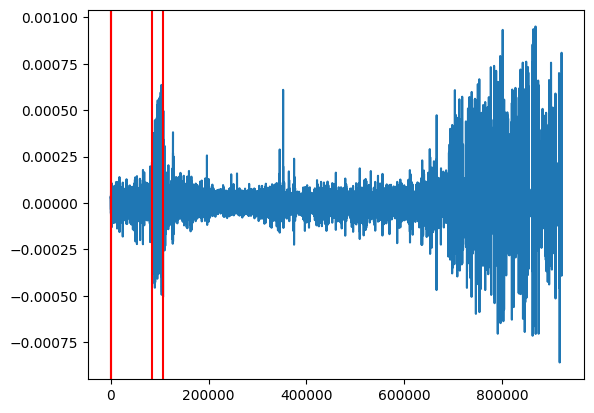

In [13]:
time = range(0,raw_data[0].size)
plt.plot(time,raw_data[0])
xcoords = openSeizure("data/chb01/chb01_21.edf.seizures")
for xc in xcoords:
    plt.axvline(x=xc, color='r')

In [7]:
def LabelData(seizurecoords, datasize, labelsize):
    labels = np.zeros(int(labelsize))
    scale = datasize/labelsize
    if len(seizurecoords) >= 4:
        for i in range(0,labels.size):
            if (i*scale>=seizurecoords[0] and i*scale<=seizurecoords[1]) or (i*scale>=seizurecoords[2] and i*scale<=seizurecoords[3]):
                labels[i]=1 #seizure = 1, otherwise = 0
    return labels

In [8]:
def MakeDataWindows(data, channels, xsize, out_data):
    s = (int(channels), int(xsize))
    scaledata = 1000
    pic = np.zeros(s)
    #print(pic[22][22])
    print(f'Running for {int(data.size/xsize/channels)} iterations')
    for i in range(int(data.size/xsize/channels)):
        for j in range(int(channels)):
            for k in range(int(xsize)):
                pic[j][k] = float(data[j][int(i * xsize + k)]) * 1000
        out_data.append(pic)
        print(
            f'\rLoop {i}',
            end=''
        )
    print(f'\nLoop Complete\n')

In [9]:
out_data = []
MakeDataWindows(raw_data, raw_data.size/raw_data[0].size, raw_data.size/raw_data[0].size, out_data)
print(f'All Done!')

Running for 40069 iterations
Loop 40068
Loop Complete

All Done!


In [10]:
seizurecoords = openSeizure("data/chb01/chb01_04.edf.seizures")
labels = LabelData(seizurecoords,raw_data[0].size,raw_data[0].size/(raw_data.size/raw_data[0].size))
#print(
#    f'\rEpoch {epoch+1} [{batch_nr+1}/{len(train_loader)}] - Loss: {loss}',
#    end=''
#)

data/chb01/chb01_04.edf.seizures
[1467, 375552, 1494, 382464]


In [11]:
print(labels[int(seizurecoords[3]/23)])
print(labels[int(seizurecoords[3]/23)+1])

1.0
0.0


In [54]:
#download custom dataset
pic = np.zeros((23, 23))
out_data = []
labels = []
done_counter = 0

#opening the text file
with open('data/chb01/chb01.txt','r') as file:
    # reading each line
    for line in file:
        a = 0
        label = -1
        row = 0
        b = 0
        # reading each word
        #sosda = np.array(line.split)
        #print(sosda.size)
        for word in line.split():
            if a == 0 and row == 0 and label == -1:
                label = int(word)
                a = a - 1
            elif row <= 22:
                b = b + 1
                pic[row][a] = int(word)
                if a >= 22:
                    row = 0
                    a = 0
                    row = row + 1
            a = a + 1
        out_data.append(pic)
        labels.append(label)
        done_counter = done_counter + 1
        print(
            f'\r{done_counter} done ({b})',
            end=''
        )

30774 done (529)

In [29]:
batch_size = 1
tensor_data = torch.Tensor(np.array(out_data))
tensor_labels = torch.Tensor(np.array(labels))
dataset = TensorDataset(tensor_data,tensor_labels)
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = int(dataset_size - train_size - val_size)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [47]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 5, 3)
        self.fc1 = nn.Linear(80, 64)
        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = torch.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [48]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    best_model = -1
    best_loss = float('inf')
    count = 0

    for epoch in range(num_epochs):
        for batch_nr, (data, labels) in enumerate(train_loader):

            with torch.set_grad_enabled(True):

                labels = torch.nn.functional.one_hot(labels.to(torch.int64), 3)

                prediction = model.forward(data)

                loss = criterion(prediction.float(), labels.float())

                loss.backward()

                optimizer.step()

                optimizer.zero_grad()

                print(
                    f'\rEpoch {epoch+1} [{batch_nr+1}/{len(train_loader)}] - Loss: {loss}',
                    end=''
                )


        total_loss = 0
        for batch_nr, (data, labels) in enumerate(val_loader):
            #labels = torch.nn.functional.one_hot(labels.to(torch.int64), 2).float()

            prediction = model.forward(data.float())

            loss = criterion(prediction, labels)

            total_loss += loss

        if total_loss < best_loss:
            best_loss = total_loss
            best_model = copy.deepcopy(model)
        #else:
            #model = copy.deepcopy(best_model)


    return best_model

In [49]:
def test_model(model, test_loader):
    correct = total = 0
    count = 0

    for batch_nr, (data, labels) in enumerate(test_loader):
        prediction = model.forward(data.float())

        if prediction.dim() == 1:
            prediction = torch.argmax(prediction).float()
            print(
                f'\rEpoch {epoch+1} [{batch_nr+1}/{len(train_loader)}] - Loss: {loss}',
                end=''
            )
            correct += bool(prediction==labels)
            total += 1
            #print(int(prediction), int(labels))

        else:
            prediction = torch.argmax(prediction, dim=1).float()
            correct += int(((prediction - labels) == 0).sum())
            total += len(prediction)
            #print(int(prediction), int(labels))

    return 100 * correct / total

In [50]:
# Load our network
model = Net()

# Define our loss function
criterion = nn.MSELoss()

# Define our optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, 10)

Epoch 10 [18464/18464] - Loss: 0.214349344372749334

In [53]:
tested_model = test_model(trained_model, train_loader)
print("model has " + str(tested_model) + "% accuracy")

model has 33.45970537261699% accuracy
